In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example(which='training_data', name='mpsa')
print(f'training N: {len(data_df)}')

# Scale y-values in absurd way
# data_df['y'] = 1000 + 100*data_df['y']

data_df.head()

training N: 16446


,x,y
0,TAAGCTTTA,-3.455265
1,GCAGCCTAT,-3.135494
2,GTGGTAAGG,2.291043
3,TGGGCGCAG,-3.147840
4,GGTGCGGGC,0.547527


In [3]:
# Set seeed
mavenn.set_seed(0)

# Define model
model = mavenn.Model(x=data_df['x'],
                     y=data_df['y'],
                     alphabet='dna',
                     gpmap_type='pairwise',
                     regression_type='GE',
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)

# Fit model to data
history = model.fit(learning_rate=.001,
                    epochs=1000,
                    early_stopping=True,
                    early_stopping_patience=20)

 
LSMR            Least-squares solution of  Ax = b

The matrix A has    16446 rows  and      612 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =      612

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  1.282e+02  8.707e+03   1.0e+00  5.3e-01
     1  5.84012e-03  1.125e+02  3.591e+03   8.8e-01  2.3e-01  1.4e+02  1.0e+00
     2  7.97211e-03  1.079e+02  2.439e+03   8.4e-01  1.2e-01  1.9e+02  1.5e+00
     3  7.49273e-03  1.043e+02  2.225e+03   8.1e-01  9.4e-02  2.3e+02  3.0e+00
     4  8.36550e-03  9.832e+01  1.787e+03   7.7e-01  4.7e-02  3.9e+02  1.3e+00
     5  9.10465e-03  9.155e+01  8.029e+02   7.1e-01  2.0e-02  4.5e+02  2.5e+00
     6  8.37513e-03  9.088e+01  5.955e+02   7.1e-01  1.4e-02  4.5e+02  2.8e+00
     7  7.05893e-03  8.997e+01  4.357e+02   7.0e-01  1.0e-02  4.7e+02  4.6e+00
     8  8.87058e-03  8.942e+01  2.351e+02   7.0e-01  5.5e-03  4.8e+02  3.1

Epoch 62/1000
264/264 [==============================] - 0s 2ms/step - loss: 37.5121 - val_loss: 36.8518
Epoch 63/1000
264/264 [==============================] - 0s 2ms/step - loss: 37.4479 - val_loss: 36.7349
Epoch 64/1000
264/264 [==============================] - 0s 2ms/step - loss: 37.4040 - val_loss: 36.8191
Epoch 65/1000
264/264 [==============================] - 0s 2ms/step - loss: 37.4135 - val_loss: 36.7207
Epoch 66/1000
264/264 [==============================] - 0s 2ms/step - loss: 37.3873 - val_loss: 36.6775
Epoch 67/1000
264/264 [==============================] - 1s 2ms/step - loss: 37.3875 - val_loss: 36.6167
Epoch 68/1000
264/264 [==============================] - 0s 2ms/step - loss: 37.3693 - val_loss: 36.6144
Epoch 69/1000
264/264 [==============================] - 0s 2ms/step - loss: 37.3621 - val_loss: 36.5797
Epoch 70/1000
264/264 [==============================] - 0s 2ms/step - loss: 37.3307 - val_loss: 36.5604
Epoch 71/1000
264/264 [==============================] 

264/264 [==============================] - 1s 3ms/step - loss: 34.4503 - val_loss: 33.9060
Epoch 140/1000
264/264 [==============================] - 1s 3ms/step - loss: 34.4347 - val_loss: 33.7722
Epoch 141/1000
264/264 [==============================] - 1s 2ms/step - loss: 34.4874 - val_loss: 33.9592
Epoch 142/1000
264/264 [==============================] - 1s 2ms/step - loss: 34.3618 - val_loss: 33.5465
Epoch 143/1000
264/264 [==============================] - 1s 2ms/step - loss: 34.4512 - val_loss: 34.6850
Epoch 144/1000
264/264 [==============================] - 1s 2ms/step - loss: 34.4716 - val_loss: 34.0317
Epoch 145/1000
264/264 [==============================] - 1s 2ms/step - loss: 34.4613 - val_loss: 34.1734
Epoch 146/1000
264/264 [==============================] - 1s 2ms/step - loss: 34.4950 - val_loss: 33.9817
Epoch 147/1000
264/264 [==============================] - 1s 3ms/step - loss: 34.4155 - val_loss: 33.9931
Epoch 148/1000
264/264 [==============================] - 1s 

In [4]:
model.save('mpsa_ge_pairwise')

Model saved to these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [5]:
# Load model
model = mavenn.load('mpsa_ge_pairwise')

Model loaded from these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [6]:
# Load test data
test_df = mavenn.load_example(which='test_data',name='mpsa')
N_test = len(test_df)
print(f'test data N: {N_test:,}')

# Scale y-values in absurd way
# test_df['y'] = 1000 + 100*test_df['y']

# Subsample indices for easy plotting
ix = np.random.rand(N_test) < 1

# Get x and y
x_test = test_df['x'].values[ix]
y_test = test_df['y'].values[ix]

test data N: 5,483


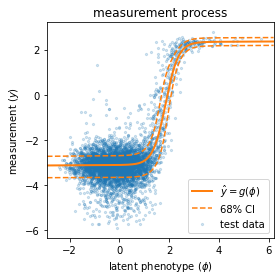

In [7]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 68% CI for each yhat
yqs_grid = model.yhat_to_yq(yhat_grid, q=[0.16, 0.84])

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

Automatically determined gpmap_type=pairwise.


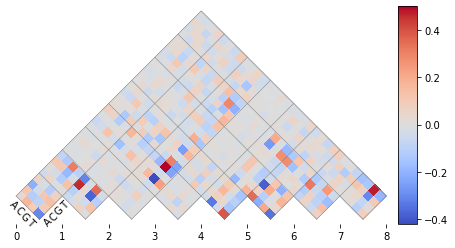

In [8]:
# Plot pairwise parameters
theta_pair_df = model.get_gpmap_parameters(which='pairwise')
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
mavenn.heatmap_pairwise(theta_pair_df, ax=ax);